# Objective:
Given a corpus, resolve noun-verb ambiguity

## 1. Import 

In [1]:
from matplotlib import pyplot as plt


import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense, Input
from keras.layers import TimeDistributed
from keras.layers import LSTM, GRU, Bidirectional, SimpleRNN, RNN
from keras.models import Model
from keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
from numpy.random import seed
seed(1)
#from tensorflow import set_random_seed
#set_random_seed(2)
import pyconll, keras, pickle, os, random, nltk, datetime, warnings, gc, urllib.request, zipfile, collections
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import recall_score, precision_score, classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.metrics.classification import UndefinedMetricWarning

from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
from keras import backend as K
from keras.models import load_model
from keras.utils import plot_model
from keras.utils.np_utils import to_categorical
import tensorflow as tf
#import tensorflow_hub as hub
import numpy as np
#import tensorflow_text
import warnings
from tqdm import tqdm_notebook
from IPython.display import Image 
#warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)
#from bert.tokenization import FullTokenizer



/opt/conda/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#!pip install pyconll

## 2. Utility Function - Read conll File and Data processing: 
This function reads conll file. Here we are creating a generic tag 'None' for all other tags except 'NOUN' and 'VERB' .

In [4]:

def read_conllu(path):
    data = pyconll.load_from_file(path)
    tagged_sentences=[]
    t=0
    for sentence in data:
        tagged_sentence=[]
        for token in sentence:
            if token.upos=='NN':
                tagged_sentence.append((token.form.lower(), str(token.upos)))
            elif token.upos=='VERB':
                tagged_sentence.append((token.form.lower(), str(token.upos)))
            else:
                tagged_sentence.append((token.form.lower(), 'None'))
        tagged_sentences.append(tagged_sentence)
    return tagged_sentences
                                   
dev = read_conllu('noun-verb/dev.conll')


In [5]:
dev[:2]

[[('once', 'None'),
  ('you', 'None'),
  ('have', 'None'),
  ('the', 'None'),
  ('new', 'None'),
  ('glass', 'None'),
  (',', 'None'),
  ('cleaning', 'VERB'),
  ('and', 'None'),
  ('replacing', 'None'),
  ('it', 'None'),
  ('is', 'None'),
  ('all', 'None'),
  ('that', 'None'),
  ("'s", 'None'),
  ('left', 'None'),
  ('.', 'None')],
 [('the', 'None'),
  ('catchment', 'None'),
  ('is', 'None'),
  ('situated', 'None'),
  ('on', 'None'),
  ('sandstone', 'None'),
  ('which', 'None'),
  ('has', 'None'),
  ('a', 'None'),
  ('low', 'None'),
  ('rate', 'None'),
  ('of', 'None'),
  ('weathering', 'VERB'),
  ('.', 'None')]]

In [6]:
train = read_conllu('noun-verb/train.conll')
test = read_conllu('noun-verb/test.conll')

In [7]:
train[0]

[('license', 'NN'),
 ('plates', 'None'),
 ('of', 'None'),
 ('cars', 'None'),
 ('from', 'None'),
 ('your', 'None'),
 ('area', 'None'),
 ('or', 'None'),
 ('your', 'None'),
 ('destination', 'None'),
 ('.', 'None')]

In [8]:
test[:2]

[[('retail', 'None'),
  ('goods', 'None'),
  ('were', 'None'),
  ('seldom', 'None'),
  ('sold', 'None'),
  ('with', 'None'),
  ('shipping', 'None'),
  ('any', 'None'),
  ('faster', 'None'),
  ('than', 'None'),
  ('overnight', 'None'),
  ('.', 'None')],
 [('if', 'None'),
  ('you', 'None'),
  ("'ve", 'None'),
  ('changed', 'None'),
  ('this', 'None'),
  (',', 'None'),
  ('press', 'VERB'),
  ('``', 'None'),
  ('preview', 'None'),
  ("''", 'None'),
  ('to', 'None'),
  ('update', 'None'),
  ('this', 'None'),
  ('message', 'None'),
  ('.', 'None')]]

In [9]:
tagged_sentences = train+dev

In [10]:
tagged_sentences[7]

[('some', 'None'),
 ('proponents', 'None'),
 ('of', 'None'),
 ('strong', 'None'),
 ('ai', 'None'),
 ('speculated', 'None'),
 ('that', 'None'),
 ('computers', 'None'),
 ('in', 'None'),
 ('connection', 'None'),
 ('with', 'None'),
 ('blue', 'None'),
 ('brain', 'None'),
 ('and', 'None'),
 ('soul', 'None'),
 ('catcher', 'None'),
 ('may', 'None'),
 ('exceed', 'None'),
 ('human', 'None'),
 ('intellectual', 'None'),
 ('capacity', 'None'),
 ('by', 'None'),
 ('around', 'None'),
 ('2015', 'None'),
 (',', 'None'),
 ('and', 'None'),
 ('that', 'None'),
 ('it', 'None'),
 ('is', 'None'),
 ('likely', 'None'),
 ('that', 'None'),
 ('we', 'None'),
 ('will', 'None'),
 ('be', 'None'),
 ('able', 'None'),
 ('to', 'None'),
 ('download', 'None'),
 ('the', 'None'),
 ('human', 'None'),
 ('brain', 'None'),
 ('at', 'None'),
 ('some', 'None'),
 ('time', 'None'),
 ('around', 'None'),
 ('2050', 'None'),
 ('.', 'None')]

In [11]:
tagged_sentences[7]

[('some', 'None'),
 ('proponents', 'None'),
 ('of', 'None'),
 ('strong', 'None'),
 ('ai', 'None'),
 ('speculated', 'None'),
 ('that', 'None'),
 ('computers', 'None'),
 ('in', 'None'),
 ('connection', 'None'),
 ('with', 'None'),
 ('blue', 'None'),
 ('brain', 'None'),
 ('and', 'None'),
 ('soul', 'None'),
 ('catcher', 'None'),
 ('may', 'None'),
 ('exceed', 'None'),
 ('human', 'None'),
 ('intellectual', 'None'),
 ('capacity', 'None'),
 ('by', 'None'),
 ('around', 'None'),
 ('2015', 'None'),
 (',', 'None'),
 ('and', 'None'),
 ('that', 'None'),
 ('it', 'None'),
 ('is', 'None'),
 ('likely', 'None'),
 ('that', 'None'),
 ('we', 'None'),
 ('will', 'None'),
 ('be', 'None'),
 ('able', 'None'),
 ('to', 'None'),
 ('download', 'None'),
 ('the', 'None'),
 ('human', 'None'),
 ('brain', 'None'),
 ('at', 'None'),
 ('some', 'None'),
 ('time', 'None'),
 ('around', 'None'),
 ('2050', 'None'),
 ('.', 'None')]

## (2.a)  Creating Input and Labels sets

In [12]:
X = [] # store input sequence
Y = [] # store output sequence

for sentence in tagged_sentences:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X.append(X_sentence)
    Y.append(Y_sentence)

In [13]:
num_words = len(set([word.lower() for sentence in X for word in sentence]))
num_tags   = len(set([word.lower() for sentence in Y for word in sentence]))

In [14]:
(set([word.lower() for sentence in Y for word in sentence]))

{'nn', 'none', 'verb'}

### Sanity Check

In [15]:
print("Total number of tagged sentences: {}".format(len(X)))
print("Vocabulary size: {}".format(num_words))
print("Total number of tags: {}".format(num_tags))

Total number of tagged sentences: 25825
Vocabulary size: 30058
Total number of tags: 3


In [16]:
# let's look at first data point
# this is one data point that will be fed to the RNN
print('sample X: ', X[0], '\n')
print('sample Y: ', Y[0], '\n')

sample X:  ['license', 'plates', 'of', 'cars', 'from', 'your', 'area', 'or', 'your', 'destination', '.'] 

sample Y:  ['NN', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'] 



In [17]:
print("Length of first input sequence  : {}".format(len(X[0])))
print("Length of first output sequence : {}".format(len(Y[0])))

Length of first input sequence  : 11
Length of first output sequence : 11


## (2.b) Tokenize input and labels

In [18]:
word_tokenizer = Tokenizer()                      
word_tokenizer.fit_on_texts(X)                    
X_encoded = word_tokenizer.texts_to_sequences(X) 

In [19]:
# encode Y

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(Y)
Y_encoded = tag_tokenizer.texts_to_sequences(Y)

### Peek on tokenized dataset

In [20]:
# look at first encoded data point

print("** Raw data point **", "\n", "-"*100, "\n")
print('X: ', X[0], '\n')
print('Y: ', Y[0], '\n')
print()
print("** Encoded data point **", "\n", "-"*100, "\n")
print('X: ', X_encoded[0], '\n')
print('Y: ', Y_encoded[0], '\n')

** Raw data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  ['license', 'plates', 'of', 'cars', 'from', 'your', 'area', 'or', 'your', 'destination', '.'] 

Y:  ['NN', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None', 'None'] 


** Encoded data point ** 
 ---------------------------------------------------------------------------------------------------- 

X:  [2698, 4986, 6, 1359, 20, 11, 204, 15, 11, 4196, 1] 

Y:  [2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1] 



### Sanity Check

In [21]:

different_length = [1 if len(input) != len(output) else 0 for input, output in zip(X_encoded, Y_encoded)]
print("{} sentences have disparate input-output lengths.".format(sum(different_length)))

0 sentences have disparate input-output lengths.


In [22]:
# check length of longest sentence
lengths = [len(seq) for seq in X_encoded]
print("Length of longest sentence: {}".format(max(lengths)))

Length of longest sentence: 157


/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


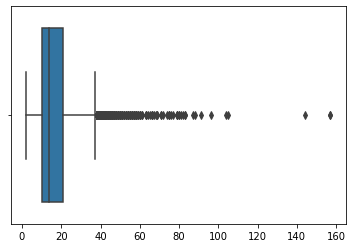

In [23]:
sns.boxplot(lengths)
plt.show()

## (2.c) Padding to tokenization

In [65]:

MAX_SEQ_LENGTH = 100  # sequences greater than 100 in length will be truncated

X_padded = pad_sequences(X_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [66]:
print(X_padded[0], "\n--"*2)
print(Y_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0 2698 4986    6 1359   20   11  204   15   11
 4196    1] 
--
--
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1 1]


In [67]:
# assign padded sequences to X and Y
X, Y = X_padded, Y_padded

## 3. Using Word Embeddings
We are using GLOVE Embedding with 300 dimensions.

In [68]:
# assign word vectors from word2vec model
import numpy as np
EMBEDDING_SIZE  = 300  # each word in word2vec model is represented using a 300 dimensional vector
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1

# create an empty embedding matix
embedding_weights = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))

# create a word to index dictionary mapping
word2id = word_tokenizer.word_index


In [69]:
! ls -lha ../dno/glove_data


total 3.0G
drwxrwxr--  2 x_dsp_otw PUBLIC 4.0K Nov 17 07:23 .
drwxrwxr-- 14 x_dsp_otw PUBLIC 8.0K Apr 26 13:42 ..
-rw-rw-r--  1 x_dsp_otw PUBLIC 332M Aug  4  2014 glove.6B.100d.txt
-rw-rw-r--  1 x_dsp_otw PUBLIC 662M Aug  4  2014 glove.6B.200d.txt
-rw-rw-r--  1 x_dsp_otw PUBLIC 990M Aug 27  2014 glove.6B.300d.txt
-rw-rw-r--  1 x_dsp_otw PUBLIC 164M Aug  4  2014 glove.6B.50d.txt
-rw-rw-r--  1 x_dsp_otw PUBLIC 823M Oct 25  2015 glove.6B.zip


## (3.a) Load Embedding from disk

In [70]:
from numpy import array
from numpy import asarray
embeddings_index = dict()
f = open('../dno/glove_data/glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs   ### eg. { 'good': [....100 values], 'bad': [.... 100 values]}
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


## (3.b) Create Embedding Matrix

In [71]:
embedding_matrix = np.zeros((VOCABULARY_SIZE, EMBEDDING_SIZE))
for word, i in word2id.items():  ## eg. {"date":1 , "person" :2 ...... "something":14369} --> every word is assigned one number
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(30059, 300)


In [72]:

print("Embeddings shape: {}".format(embedding_matrix.shape))

Embeddings shape: (30059, 300)


In [73]:
# let's look at an embedding of a word
embedding_matrix[word_tokenizer.word_index['language']]

array([-6.78319991e-01, -2.86579996e-01, -2.89039999e-01,  1.50989994e-01,
       -4.67200011e-01, -1.74239993e-01, -7.77899981e-01,  3.54689986e-01,
        6.94309995e-02, -1.74090004e+00, -4.86990018e-03,  3.28130007e-01,
       -5.54430008e-01,  5.13880014e-01,  5.30650020e-01,  2.37179995e-02,
        2.25419998e-01,  7.68660009e-01,  1.83479995e-01,  1.67649999e-01,
       -1.52930006e-01, -2.72009999e-01, -5.33890016e-02,  1.07270002e+00,
       -4.66780007e-01, -2.45959997e-01,  1.92049995e-01, -7.61379972e-02,
        3.97749990e-02,  1.65460005e-01,  6.41880035e-02,  4.12070006e-01,
       -4.12900001e-01,  8.81760001e-01, -6.55099988e-01, -1.99939996e-01,
        2.80360013e-01, -8.30579996e-01,  1.03740003e-02,  2.50169992e-01,
       -2.70720005e-01, -5.80580011e-02,  4.07059997e-01, -2.38710001e-01,
        1.89649999e-01, -4.79299985e-02, -2.00269997e-01,  8.79830003e-01,
       -1.58519998e-01, -2.81040013e-01,  1.54970005e-01, -4.32070009e-02,
        4.27940011e-01, -

In [74]:
# one-hot encode Y
Y = to_categorical(Y)

In [75]:
print(Y.shape)

(25825, 100, 4)


## 4) Test Train split

In [76]:
TEST_SIZE = 0.15
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=11023)

In [77]:
# split training data into training and validation sets
VALID_SIZE = 0.15
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=VALID_SIZE, random_state=4)

In [78]:
# print number of samples in each set
print("TRAINING DATA")
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print("-"*50)
print("VALIDATION DATA")
print('Shape of input sequences: {}'.format(X_validation.shape))
print('Shape of output sequences: {}'.format(Y_validation.shape))
print("-"*50)
print("TESTING DATA")
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))

TRAINING DATA
Shape of input sequences: (18658, 100)
Shape of output sequences: (18658, 100, 4)
--------------------------------------------------
VALIDATION DATA
Shape of input sequences: (3293, 100)
Shape of output sequences: (3293, 100, 4)
--------------------------------------------------
TESTING DATA
Shape of input sequences: (3874, 100)
Shape of output sequences: (3874, 100, 4)


In [79]:
# total number of tags
NUM_CLASSES = Y.shape[2]

## 5. Create BiLSTM Model

We experimented various BiLSTM architectures. Finally we used BiLSTM models and made embedding Trainable (In order to add contextual information to our Embedding)

In [80]:
# create architecture

bidirect_model = Sequential()
bidirect_model.add(Embedding(input_dim     = VOCABULARY_SIZE,
                             output_dim    = EMBEDDING_SIZE,
                             input_length  = MAX_SEQ_LENGTH,
                             weights       = [embedding_matrix],
                             trainable     = True
))
bidirect_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bidirect_model.add(TimeDistributed(Dense(NUM_CLASSES, activation='softmax')))

In [81]:
bidirect_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9017700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 4)            516       
Total params: 9,205,096
Trainable params: 9,205,096
Non-trainable params: 0
_________________________________________________________________


In [82]:
bidirect_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [83]:
# check summary of model
bidirect_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          9017700   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          186880    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 100, 4)            516       
Total params: 9,205,096
Trainable params: 9,205,096
Non-trainable params: 0
_________________________________________________________________


## (5.b) Model Training

In [84]:
bidirect_training = bidirect_model.fit(X_train, Y_train, batch_size=128, epochs=10, validation_data=(X_validation, Y_validation))

Epoch 1/10
146/146 [==============================] - 55s 351ms/step - loss: 0.3273 - acc: 0.9548 - val_loss: 0.0177 - val_acc: 0.9963
Epoch 2/10
146/146 [==============================] - 51s 349ms/step - loss: 0.0163 - acc: 0.9966 - val_loss: 0.0138 - val_acc: 0.9968
Epoch 3/10
146/146 [==============================] - 52s 358ms/step - loss: 0.0123 - acc: 0.9971 - val_loss: 0.0119 - val_acc: 0.9969
Epoch 4/10
146/146 [==============================] - 49s 336ms/step - loss: 0.0103 - acc: 0.9973 - val_loss: 0.0110 - val_acc: 0.9970
Epoch 5/10
146/146 [==============================] - 47s 324ms/step - loss: 0.0088 - acc: 0.9975 - val_loss: 0.0106 - val_acc: 0.9970
Epoch 6/10
146/146 [==============================] - 47s 320ms/step - loss: 0.0081 - acc: 0.9975 - val_loss: 0.0104 - val_acc: 0.9971
Epoch 7/10
146/146 [==============================] - 47s 322ms/step - loss: 0.0071 - acc: 0.9977 - val_loss: 0.0105 - val_acc: 0.9970
Epoch 8/10
146/146 [==============================] - 4

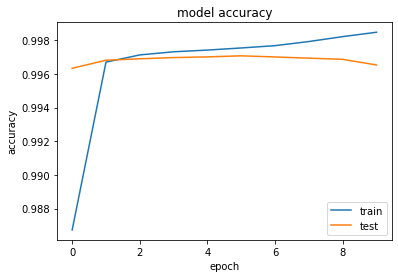

In [85]:
# visualise training history
plt.plot(bidirect_training.history['acc'])
plt.plot(bidirect_training.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc="lower right")
plt.show()


## (5.c) Model Evaluation

In [86]:
bidirect_model.evaluate(X_validation, Y_validation)

103/103 [==============================] - 3s 28ms/step - loss: 0.0125 - acc: 0.9965


[0.012544321827590466, 0.996535062789917]

In [87]:
bidirect_model.evaluate(X_test, Y_test)

122/122 [==============================] - 4s 30ms/step - loss: 0.0128 - acc: 0.9965


[0.01276367250829935, 0.9965307116508484]

## 6. Model Perfomance of held out Test dataset

In [106]:
test = read_conllu('noun-verb/test.conll')

In [107]:
X_val = [] # store input sequence
Y_val = [] # store output sequence

for sentence in test:
    X_sentence = []
    Y_sentence = []
    for entity in sentence:         
        X_sentence.append(entity[0])  # entity[0] contains the word
        Y_sentence.append(entity[1])  # entity[1] contains corresponding tag
        
    X_val.append(X_sentence)
    Y_val.append(Y_sentence)

In [108]:
X_val_encoded = word_tokenizer.texts_to_sequences(X_val) 
Y_val_encoded = tag_tokenizer.texts_to_sequences(Y_val)

In [109]:
MAX_SEQ_LENGTH = 100 # sequences greater than 100 in length will be truncated

X_val_padded = pad_sequences(X_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
Y_val_padded = pad_sequences(Y_val_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")

In [110]:
X_val, Y_val = X_val_padded, Y_val_padded

In [111]:
Y_val = to_categorical(Y_val)

In [112]:
bidirect_model.evaluate(X_val, Y_val)

185/185 [==============================] - 6s 30ms/step - loss: 0.0771 - acc: 0.9871


[0.07708165794610977, 0.9870611429214478]